In [1]:
# huggingface
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler
import torch
from torch.profiler import profile, record_function, ProfilerActivity
from tqdm.auto import trange

import time
import pandas as pd

text_to_im_model_id = "stabilityai/stable-diffusion-2"

scheduler = EulerDiscreteScheduler.from_pretrained(text_to_im_model_id, subfolder="scheduler")
pipe = StableDiffusionPipeline.from_pretrained(text_to_im_model_id, scheduler=scheduler, revision="fp16", torch_dtype=torch.float16)
pipe = pipe.to("cuda")

if text_to_im_model_id=="stability/stable-diffusion-2":
    pipe.enable_attention_slicing()

# image gen params
temperature = 0.7
max_length = 42
guidance_scale = 7.5
height = 768
width = 768
steps = 100
num_loops = 1

def makeimage(pipe, prompt):
    prompt = "<s>Prompt: " + prompt + ","
    for _ in trange(num_loops):
        image = pipe(prompt, 
                    num_inference_steps=steps, 
                    height=height, width=width,
                    guidance_scale=guidance_scale).images[0]  
        image.save("output.png")

    return image

/home/mykola/projects/diffusion/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def run_profiler(pipe, prompt):
    with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True, record_shapes=False) as prof:
        with record_function("model_inference"):
            start_time = time.perf_counter()
            image = makeimage(pipe, prompt)
            final_time = time.perf_counter()

    total_time = final_time - start_time
    profiler_results = prof.key_averages()

    return profiler_results, total_time, image

In [7]:
def extract_timings(profiler_results):
    rows = []
    for summary in profiler_results:
        # if summary.key != "model_inference":
        #     continue
        row = {
            "name": summary.key,
            "cpu_time_total": summary.cpu_time_total,
            "cuda_time_total": summary.cuda_time_total,
            "self_cpu_time_total": summary.self_cpu_time_total,
            "self_cuda_time_total": summary.self_cuda_time_total,
            "cpu_memory_usage": summary.cpu_memory_usage,
            "cuda_memory_usage": summary.cuda_memory_usage,
            "self_cpu_memory_usage": summary.self_cpu_memory_usage,
            "self_cuda_memory_usage": summary.self_cuda_memory_usage,
            # "cpu_time_str": summary.cpu_time_str,
            # "cuda_time_str": summary.cuda_time_str,
            # "cpu_time_total_str": summary.cpu_time_total_str,
            # "cuda_time_total_str": summary.cuda_time_total_str,
            # "self_cpu_time_total_str": summary.self_cpu_time_total_str,
            # "self_cuda_time_total_str": summary.self_cuda_time_total_str,
            "cpu_time": summary.cpu_time,
            "cuda_time": summary.cuda_time,
            "count": summary.count
        }
        rows.append(row)
    return pd.DataFrame(rows)

In [8]:
def collect_profiler_info(pipe, prompt):
    profiler_results, total_time, image = run_profiler(pipe, prompt)
    timings_df = extract_timings(profiler_results)
    timings_df["total_time"] = total_time
    return timings_df, image

In [9]:
df, image = collect_profiler_info(pipe, "A fox in space")

STAGE:2023-04-17 18:40:43 6900:6900 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
100%|██████████| 1/1 [00:25<00:00, 25.02s/it]
STAGE:2023-04-17 18:41:09 6900:6900 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-04-17 18:41:09 6900:6900 ActivityProfilerController.cpp:321] Completed Stage: Post Processing


In [11]:
# sort by cpu_time_total
# df.sort_values(by="cpu_time_total", ascending=False)[:10]

# sort by total cpu memory
df.sort_values(by="cpu_memory_usage", ascending=False)[:10]

,name,cpu_time_total,cuda_time_total,self_cpu_time_total,self_cuda_time_total,cpu_memory_usage,cuda_memory_usage,self_cpu_memory_usage,self_cuda_memory_usage,cpu_time,cuda_time,count,total_time
2,aten::to,339532,3935,600,0,10616836,509841920,0,14848,7.845009e+01,9.091959e-01,4328,25.023545
6,aten::_to_copy,339279,3963,1018,0,10616836,509841920,0,0,1.592859e+03,1.860563e+01,213,25.023545
7,aten::empty_strided,1033,0,1033,0,10616836,509841920,10616836,509841920,4.849765e+00,0.000000e+00,213,25.023545
1,aten::empty,143204,0,143204,0,25664,121264107520,25664,121264107520,2.223043e+00,0.000000e+00,64418,25.023545
76,aten::pow,7509,511,5038,511,4000,256000,4000,256000,1.498802e+01,1.019960e+00,501,25.023545
75,aten::div,35935,68783,22910,68783,4000,12192405504,4000,12192405504,1.322598e+01,2.531579e+01,2717,25.023545
73,aten::rsub,23,0,6,0,4000,0,8,0,2.300000e+01,0.000000e+00,1,25.023545
74,aten::sub,4156,357,2762,357,3992,14796800,3988,14796800,1.380731e+01,1.186047e+00,301,25.023545
0,model_inference,25023598,24301476,1340525,0,0,0,-10654496,-553009340416,2.502360e+07,2.430148e+07,1,25.023545
143,aten::_efficient_attention_forward,53478,6354810,22408,6354810,0,21263155200,0,0,1.671187e+01,1.985878e+03,3200,25.023545


In [14]:
profiler_results, total_time, image=run_profiler(pipe, "A fox in space")

STAGE:2023-04-17 18:15:21 4006:4006 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
100%|██████████| 1/1 [00:24<00:00, 24.77s/it]
STAGE:2023-04-17 18:15:46 4006:4006 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-04-17 18:15:46 4006:4006 ActivityProfilerController.cpp:321] Completed Stage: Post Processing


In [15]:
print(profiler_results.table(sort_by="cpu_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference         5.03%        1.245s       100.00%       24.768s       24.768s       0.000us         0.00%       24.119s       24.119s           0 b     -10.15 Mb           0 b    -519.98 G

In [10]:
# prompt = 'A man in space'

# start_time = time.perf_counter()

# with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True, record_shapes=False) as prof:
#     with record_function("model_inference"):
#         image = makeimage(pipe, prompt)

#         final_time = time.perf_counter()

# pforiler_results = prof.key_averages().table(sort_by="cpu_time_total", row_limit=10)

# # print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))
# print(pforiler_results)

# total_time = final_time - start_time
# print(f"Total time: {total_time}")

In [2]:
# prof.key_averages().table(row_limit=10)

In [3]:
# # convert to pandas dataframe
# import pandas as pd
# df = prof.key_averages().table(sort_by="cpu_time_total", row_limit=10).to_pandas()

# # the previous method didn't work, so try this one

In [4]:
# prof.key_averages().table(sort_by="cpu_time_total", row_limit=10)

In [5]:
# print(pforiler_results)

In [6]:
# print(prof.key_averages())

In [7]:
# import pandas as pd
# # import StringIO
# from io import StringIO

In [8]:
# df = pd.read_csv(StringIO(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10)))

In [9]:
# summaries = prof.key_averages()

In [44]:
# rows = []
# for summary in summaries:
#     name = summary.key
#     cpu_time_total = summary.cpu_time_total
#     cuda_time_total = summary.cuda_time_total
#     self_cpu_time_total = summary.self_cpu_time_total
#     self_cuda_time_total = summary.self_cuda_time_total
#     cpu_memory_usage = summary.cpu_memory_usage
#     cuda_memory_usage = summary.cuda_memory_usage
#     self_cpu_memory_usage = summary.self_cpu_memory_usage
#     self_cuda_memory_usage = summary.self_cuda_memory_usage
#     cpu_time_str = summary.cpu_time_str
#     cuda_time_str = summary.cuda_time_str
#     cpu_time_total_str = summary.cpu_time_total_str
#     cuda_time_total_str = summary.cuda_time_total_str
#     self_cpu_time_total_str = summary.self_cpu_time_total_str
#     self_cuda_time_total_str = summary.self_cuda_time_total_str
#     cpu_time = summary.cpu_time
#     cuda_time = summary.cuda_time
#     count = summary.count
    
#     row = {
#         "name": name,
#         "cpu_time_total": cpu_time_total,
#         "cuda_time_total": cuda_time_total,
#         "self_cpu_time_total": self_cpu_time_total,
#         "self_cuda_time_total": self_cuda_time_total,
#         "cpu_memory_usage": cpu_memory_usage,
#         "cuda_memory_usage": cuda_memory_usage,
#         "self_cpu_memory_usage": self_cpu_memory_usage,
#         "self_cuda_memory_usage": self_cuda_memory_usage,
#         "cpu_time_str": cpu_time_str,
#         "cuda_time_str": cuda_time_str,
#         "cpu_time_total_str": cpu_time_total_str,
#         "cuda_time_total_str": cuda_time_total_str,
#         "self_cpu_time_total_str": self_cpu_time_total_str,
#         "self_cuda_time_total_str": self_cuda_time_total_str,
#         "cpu_time": cpu_time,
#         "cuda_time": cuda_time,
#         "count": count
#     }
#     rows.append(row)

#     # dirs = summary.__dir__()
#     # for dir in dirs:
#     #     if not dir.startswith("_"):
#     #         print(dir, getattr(summary, dir))
#     # break

# df = pd.DataFrame(rows)

In [ ]:
# def extract_timings(profiler_results):
#     rows = []
#     for summary in profiler_results:
#         row = {
#             "name": summary.key,
#             "cpu_time_total": summary.cpu_time_total,
#             "cuda_time_total": summary.cuda_time_total,
#             "self_cpu_time_total": summary.self_cpu_time_total,
#             "self_cuda_time_total": summary.self_cuda_time_total,
#             "cpu_memory_usage": summary.cpu_memory_usage,
#             "cuda_memory_usage": summary.cuda_memory_usage,
#             "self_cpu_memory_usage": summary.self_cpu_memory_usage,
#             "self_cuda_memory_usage": summary.self_cuda_memory_usage,
#             "cpu_time_str": summary.cpu_time_str,
#             "cuda_time_str": summary.cuda_time_str,
#             "cpu_time_total_str": summary.cpu_time_total_str,
#             "cuda_time_total_str": summary.cuda_time_total_str,
#             "self_cpu_time_total_str": summary.self_cpu_time_total_str,
#             "self_cuda_time_total_str": summary.self_cuda_time_total_str,
#             "cpu_time": summary.cpu_time,
#             "cuda_time": summary.cuda_time,
#             "count": summary.count
#         }
#         rows.append(row)
#     return pd.DataFrame(rows)

In [13]:
# print(df)

In [46]:
df.to_csv("profile.csv", index=False, header=True)

In [42]:
prof.key_averages()

[<FunctionEventAvg key=model_inference self_cpu_time=1.211s cpu_time=25.415s  self_cuda_time=0.000us cuda_time=27.438s input_shapes= cpu_memory_usage=0 cuda_memory_usage=8521216>,
 <FunctionEventAvg key=aten::empty self_cpu_time=149.071ms cpu_time=2.324us  self_cuda_time=0.000us cuda_time=0.032us input_shapes= cpu_memory_usage=26376 cuda_memory_usage=123099233280>,
 <FunctionEventAvg key=aten::to self_cpu_time=800.000us cpu_time=67.830us  self_cuda_time=0.000us cuda_time=1.867us input_shapes= cpu_memory_usage=10616836 cuda_memory_usage=509841920>,
 <FunctionEventAvg key=aten::lift_fresh self_cpu_time=1.000us cpu_time=0.100us  self_cuda_time=0.000us cuda_time=0.000us input_shapes= cpu_memory_usage=0 cuda_memory_usage=0>,
 <FunctionEventAvg key=aten::detach_ self_cpu_time=11.000us cpu_time=1.750us  self_cuda_time=0.000us cuda_time=0.000us input_shapes= cpu_memory_usage=0 cuda_memory_usage=0>,
 <FunctionEventAvg key=detach_ self_cpu_time=3.000us cpu_time=0.375us  self_cuda_time=0.000us cu

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [10]:
dfs = []
for si in [256, 512, 768]:
    for st in [10, 50, 100, 200]:
        df = pd.read_csv(f"results/timings_{si}_{st}.csv")
        df["size"] = si
        df["steps"] = st
        dfs.append(df)

df = pd.concat(dfs)

df["cpu_time_total"] = df["cpu_time_total"] / 1e6

<Axes: xlabel='steps', ylabel='total_time'>

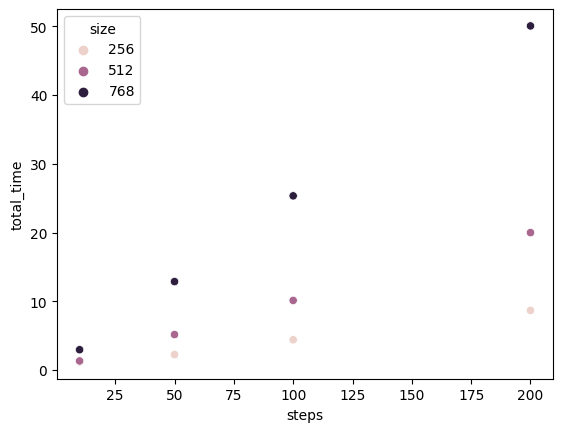

In [12]:
sns.scatterplot(data=df, x="steps", y="total_time", hue="size")